In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 데이터 로드

In [2]:
path = '../아림경영/데이터/기업별 뉴스'

In [3]:
df = pd.read_excel('../데이터/기업별 뉴스/CMG제약.xlsx',   sheet_name='#02 Documents')
df.head(1)

,date,category,section,publisher,author,title,content_url,attachment,industry.label,industry.score,industry.name,polarity.label,polarity.score,polarity.name
0,2023-05-22,news,economy,조선비즈,NaN,"차병원·바이오그룹, R&D·영업마케팅 경력 공개 채용",NaN,NaN,C21,0.969,의료용 물질 및 의약품 제조업,NaN,NaN,NaN


In [4]:
df = df[['date','title','polarity.label']]
df.head(1)


,date,title,polarity.label
0,2023-05-22,"차병원·바이오그룹, R&D·영업마케팅 경력 공개 채용",NaN


# 데이터 라벨 값 변환

In [5]:
df['polarity.label'] = df['polarity.label'].replace(-1,2)

In [6]:
df['polarity.label'].unique()

array([nan,  1.,  0.,  2.])

# 중복값 확인

In [7]:
duplicate = df[df.duplicated()]
duplicate

,date,title,polarity.label


In [8]:
# polarity.label  = [긍정,중립,부정]
# polarity.name   = [1,0,2]

<AxesSubplot: >

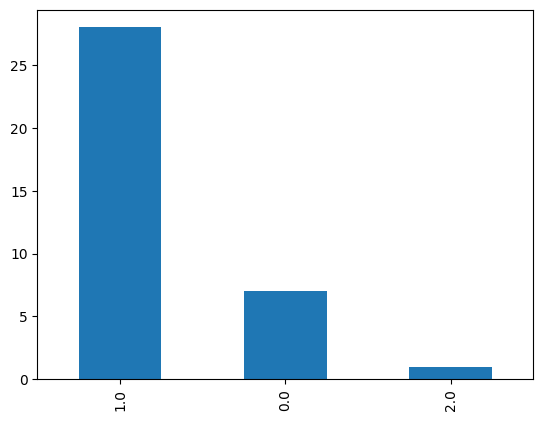

In [9]:
df['polarity.label'].value_counts().plot(kind='bar')

In [10]:
mecab = mecab.MeCab()

In [11]:
df['tokenized'] = df['title'].apply(mecab.morphs)

In [13]:
df.head(2)

,date,title,polarity.label,tokenized
0,2023-05-22,"차병원·바이오그룹, R&D·영업마케팅 경력 공개 채용",NaN,"[차, 병원, ·, 바이오, 그룹, ,, R, &, D, ·, 영업, 마케팅, 경력..."
1,2023-05-05,"""매출, 올해 50%·내년 두배 ↑""…마더스제약, 성장 자신하는 이유",NaN,"["", 매출, ,, 올해, 50, %·, 내년, 두, 배, ↑""…, 마더, 스, 제..."


# 훈련-테스트

In [19]:
# train = df[df['polarity.label'].notna()]
# test = df[df['polarity.label'].isna()]

<AxesSubplot: >

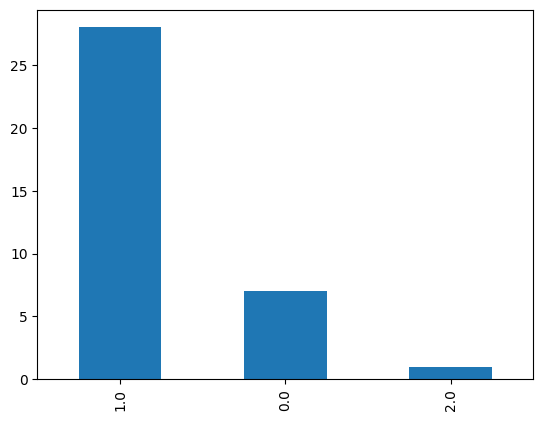

In [20]:
# train['polarity.label'].value_counts().plot(kind='bar')

In [22]:
# X_train = train['tokenized']
# y_train = train['polarity.label']

In [23]:
# X_test = test['tokenized']
# y_test = test['polarity.label']

# tokenize

In [24]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x211ea4c5610>)

# Data Load

In [25]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [26]:
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
data[:2]

,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...


In [27]:
del data['sentence']

In [28]:
data[:2]

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [30]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [31]:
print('kor_sentence 열의 유니크한 값 :',data['kor_sentence'].nunique())

kor_sentence 열의 유니크한 값 : 4827


In [32]:
duplicate = data[data.duplicated()]

In [33]:
duplicate.head(1)

,labels,kor_sentence
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.


In [34]:
# 중복 제거
data.drop_duplicates(subset=['kor_sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4827


<AxesSubplot: >

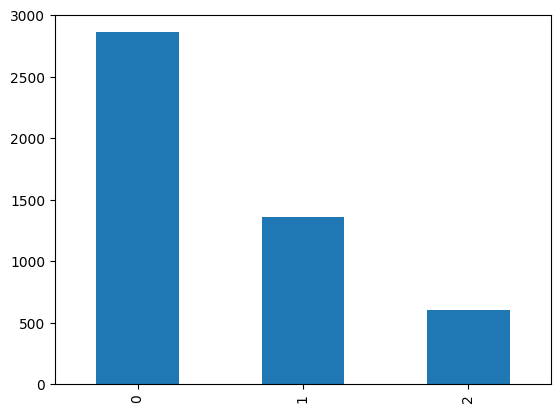

In [35]:
data['labels'].value_counts().plot(kind='bar')

In [36]:
print('레이블의 분포')
print(data.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0       0   2861
1       1   1362
2       2    604


In [37]:
print(f'중립의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')

중립의 비율 = 59.271%
긍정의 비율 = 28.216%
부정의 비율 = 12.513%


In [39]:
data['tokenized'] = data['kor_sentence'].apply(mecab.morphs)

In [40]:
data.head(2)

,labels,kor_sentence,tokenized
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...","[Gran, 에, 따르, 면, ,, 그, 회사, 는, 회사, 가, 성장, 하, 고,..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,"[테크노폴리스, 는, 컴퓨터, 기술, 과, 통신, 분야, 에서, 일, 하, 는, 회..."


In [21]:
X_data = data['tokenized']
y_data = data['labels']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4827
레이블의 개수: 4827


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[390, 199, 4, 299, 170, 128, 2, 150, 15, 299, 170, 2075, 331, 10, 4, 1156, 5, 567, 29, 20, 22, 151, 10, 16, 14, 3, 1], [1157, 1158, 4, 92, 5, 43, 36, 50, 13, 47, 208, 16, 13, 3, 1], [5, 95, 2, 55, 7, 19, 1, 38, 44, 15, 48, 1, 52, 44, 22, 50, 13, 3, 1], [515, 4, 2076, 4504, 6, 84, 283, 157, 8, 609, 638, 160, 2, 2480, 474, 1066, 157, 6, 2077, 29, 20, 8, 284, 13, 3, 1], [165, 339, 7, 1426, 265, 76, 15, 1426, 332, 76, 699, 18, 475, 212, 1]]
[[868, 792, 7, 113, 140, 6, 88, 332, 27, 17, 12, 114, 77, 1], [97, 1917, 211, 184, 2, 4295, 2503, 23, 401, 24, 770, 6, 174, 364, 34, 16, 190, 61, 20, 5, 69, 28, 330, 7, 51, 13, 3, 1], [672, 160, 376, 882, 30, 238, 31, 4, 156, 2, 3463, 1088, 5, 21, 5286, 159, 2, 964, 12, 2873, 10, 4, 20, 5, 69, 1143, 13, 3, 1], [412, 38, 65, 150, 7, 58, 11, 231, 95, 2, 19, 1, 48, 206, 17, 15, 19, 1, 43, 206, 17, 18, 452, 3, 1], [71, 11, 43, 26, 511, 40, 653, 19, 205, 98, 571, 105, 1, 5241, 2, 1196, 328, 3118, 19, 37, 71, 6, 84, 271, 2474, 7, 71, 11, 19, 26, 123, 38, 26,

In [27]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

8942


## 패딩

In [28]:
X_train[:2]

2049    [보험, 사, 는, 노르, 데, 아, 의, 순이익, 에서, 노르, 데, 아가, 차지...
129     [백화점, 부서, 는, 매출, 이, 4, %, 증가, 했, 다고, 보, 고, 했, ...
Name: tokenized, dtype: object

본문의 최대 길이 : 76
본문의 평균 길이 : 28.235431235431236


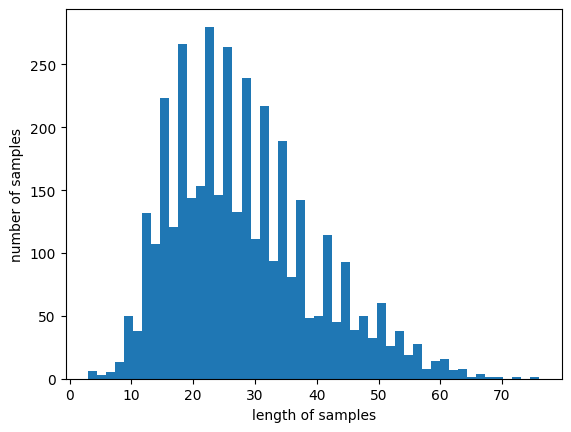

In [29]:
print(  '본문의 최대 길이 :',   max(   len(sent) for sent in X_train   )   )
# X_train 요소 하나하나 길이 재서 최대길이추출
print(   '본문의 평균 길이 :',  sum(    map(len, X_train)  )   /  len(X_train)     )
# X_train 요소 길이 재서 sum하구 X_train 개수로 나눈다
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
max_len = 76

In [31]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [38]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [39]:
embedding_dim = 64
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
97/97 [==============================] - ETA: 0s - loss: 0.8955 - acc: 0.6062
Epoch 1: val_acc improved from -inf to 0.71151, saving model to best_model.h5
97/97 [==============================] - 5s 36ms/step - loss: 0.8955 - acc: 0.6062 - val_loss: 0.7417 - val_acc: 0.7115
Epoch 2/15
95/97 [============================>.] - ETA: 0s - loss: 0.6261 - acc: 0.7326
Epoch 2: val_acc improved from 0.71151 to 0.75162, saving model to best_model.h5
97/97 [==============================] - 3s 28ms/step - loss: 0.6246 - acc: 0.7332 - val_loss: 0.6565 - val_acc: 0.7516
Epoch 3/15
95/97 [============================>.] - ETA: 0s - loss: 0.3302 - acc: 0.8832
Epoch 3: val_acc did not improve from 0.75162
97/97 [==============================] - 3s 31ms/step - loss: 0.3316 - acc: 0.8828 - val_loss: 0.7574 - val_acc: 0.7503
Epoch 4/15
97/97 [==============================] - ETA: 0s - loss: 0.1705 - acc: 0.9475
Epoch 4: val_acc did not improve from 0.75162
97/97 [==========================

In [40]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_encoded, y_test)[1]))

31/31 [==============================] - 1s 11ms/step - loss: 0.6164 - acc: 0.7640

 테스트 정확도: 0.7640
